In [68]:
# Imports
import numpy as np
import pandas as pd
import time
import datetime

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

#seaborn
import seaborn as sns

#ploty
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

!pip install pmdarima
from pmdarima.arima import auto_arima

In [69]:
# 1 Data Processing

In [70]:
# 1.1 Data Importing
df = pd.read_csv('prices-split-adjusted.csv',index_col='date', parse_dates=['date'])
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [71]:
# 1.2 Extracting Apple Pricing Data
stock_name = 'AAPL'
stock = df[df['symbol'] == stock_name]
stock.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,79.427744,79.402683,78.640034,80.140447,9.422578e+07
std,28.339001,28.330794,28.108525,28.561027,6.020519e+07
min,27.481428,27.435715,27.178572,28.000000,1.147590e+07
25%,55.401787,55.450000,54.672501,55.909286,4.917478e+07
50%,78.742146,78.435711,77.631428,79.344284,8.050385e+07
75%,102.979998,103.092503,102.500000,104.424997,1.210816e+08
max,134.460007,133.000000,131.399994,134.539993,4.702495e+08


In [72]:
# 2. Exploring The Data

In [73]:
# 2.1 Apple Stock Price
fig = px.line(stock, y="close", title=stock_name+' Close Value')
fig.show()

In [74]:
# 2.2 Apple Closing Pirce
stock_returns = stock['close'].pct_change()
fig = px.line(stock_returns, title=stock_name+' Stocks returns')
fig.show()

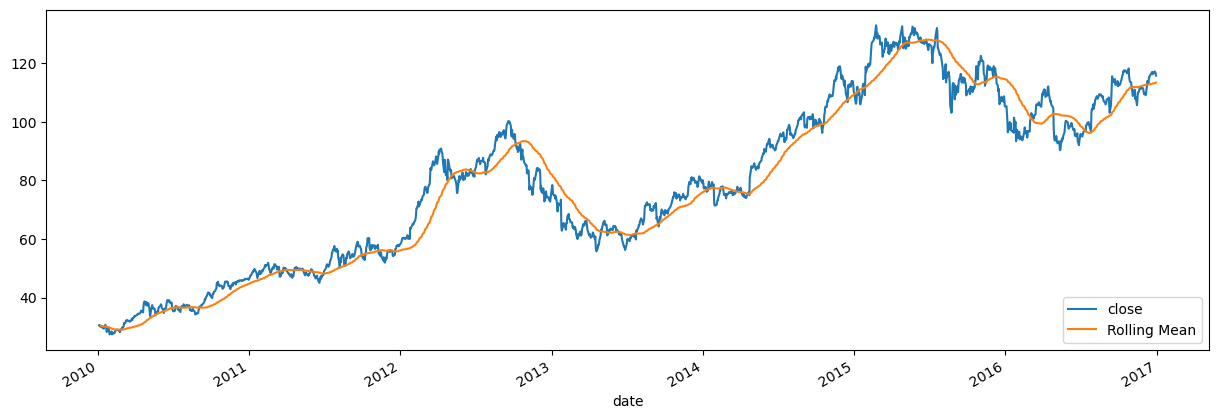

In [75]:
# 2.3 Apple Closing Price - Rolling Mean
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
stock_rolling = stock['close'].rolling(window=60,min_periods=5).mean()
stock['close'].plot()
stock_rolling.plot()
plt.legend(['close','Rolling Mean'])
plt.show()

C:\Users\brand\AppData\Local\Temp\ipykernel_18424\1238475444.py:4: FutureWarning:

The `center` argument on `expanding` will be removed in the future.



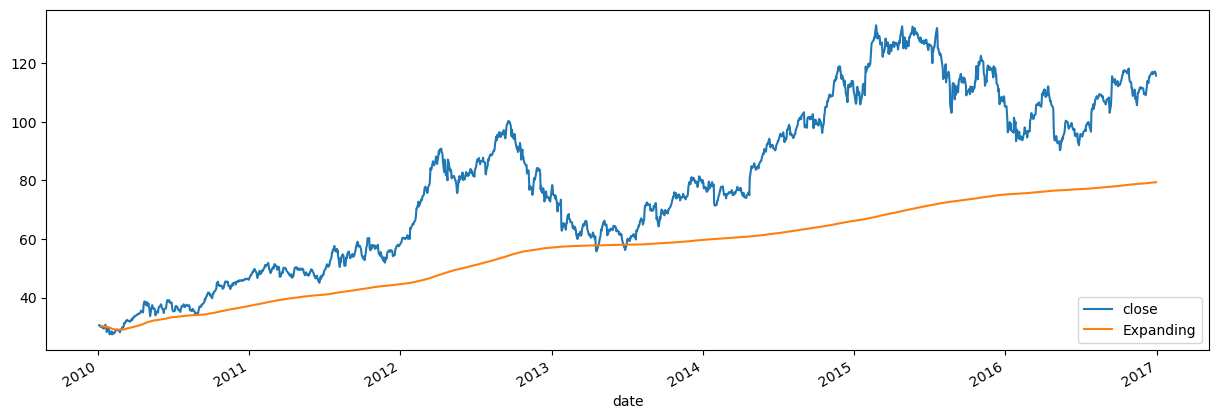

In [76]:
# 2.4 Apple Closing Price - Expanding
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
stock_expanding = stock['close'].expanding(min_periods=5,center=True).mean()
stock['close'].plot()
stock_expanding.plot()
plt.legend(['close','Expanding'])
plt.show()

In [77]:
# 2.5 Stock Density Distribution

C:\Users\brand\AppData\Local\Temp\ipykernel_18424\1452612172.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='close', ylabel='Density'>

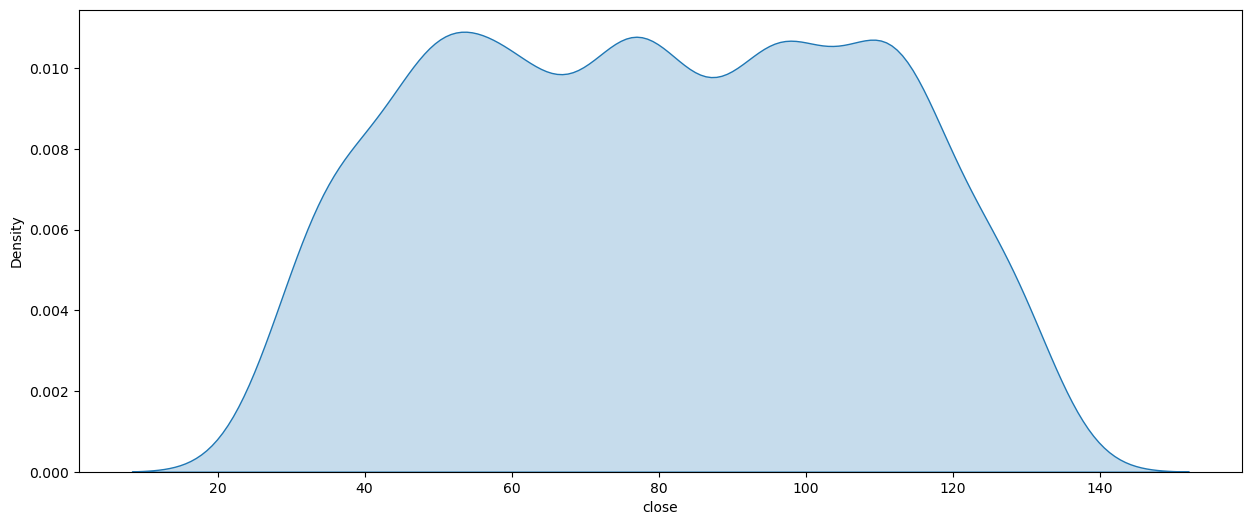

In [78]:
sns.kdeplot(stock['close'],shade=True)

In [79]:
# 3 Modeling 

In [80]:
# 3.1 Dicky fuller test to see if the returns is a random walk

stock_returns = stock['close'].pct_change()
stock_returns = stock_returns.dropna()
results = adfuller(stock_returns)
print(results)
print('The p-value of the test on prices is: ' + str(results[1]))

# With a p-value of 0, we can say that the data is not random and the sereis follows a stationary time series.
# This will allow us to utilize an ARMA model.

(-40.986288059289976, 0.0, 0, 1760, {'1%': -3.4340709449678415, '5%': -2.8631835901181564, '10%': -2.567644997740186}, -9333.109811446033)
The p-value of the test on prices is: 0.0


In [81]:
# 3.2 Autocorrelation
print(stock_returns.autocorr())
weekly_returns = stock.resample(rule='W').mean()['close'].pct_change()
print(weekly_returns.autocorr())
monthly_returns = stock.resample(rule='M').mean()['close'].pct_change()
print(monthly_returns.autocorr())
yearly_returns = stock.resample(rule='A').mean()['close'].pct_change()
print(yearly_returns.autocorr())

# We can conclude that the data is slightly negatively autocorrelated

0.022644852046409224
0.20915252759854322
0.2799232320101034
-0.3790285810653072


C:\Users\brand\AppData\Local\Temp\ipykernel_18424\1636029168.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\brand\AppData\Local\Temp\ipykernel_18424\1636029168.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\brand\AppData\Local\Temp\ipykernel_18424\1636029168.py:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



C:\Users\brand\AppData\Local\Temp\ipykernel_18424\2538891068.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



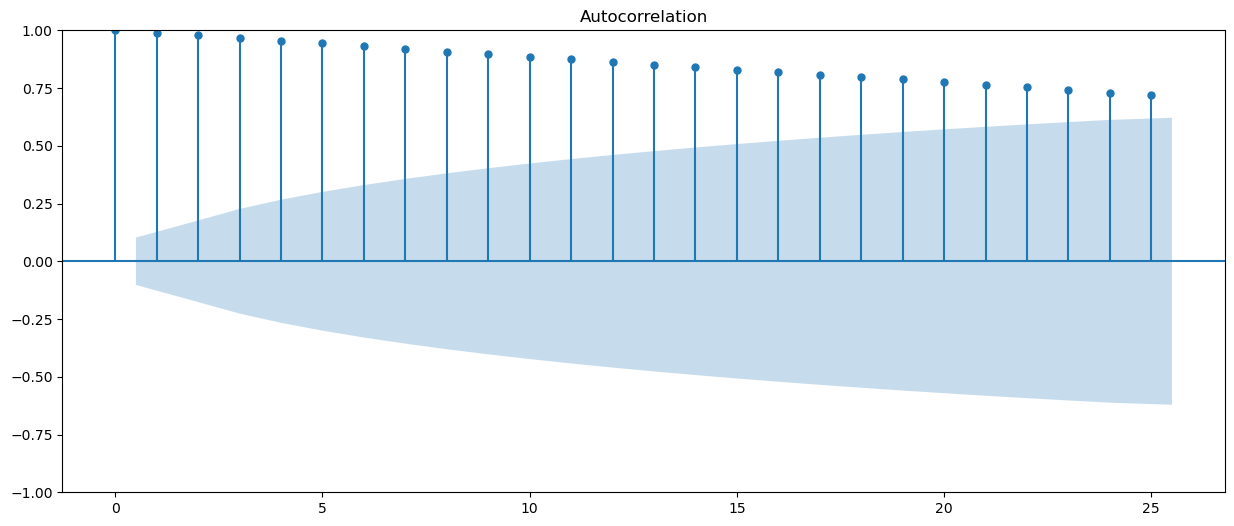

In [82]:
# 3.3 ACF (Autocorrelation Function)
plot_acf(stock.resample(rule='W').mean()['close'],alpha=0.05,lags=25)
plt.show()

C:\Users\brand\AppData\Local\Temp\ipykernel_18424\2562213823.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



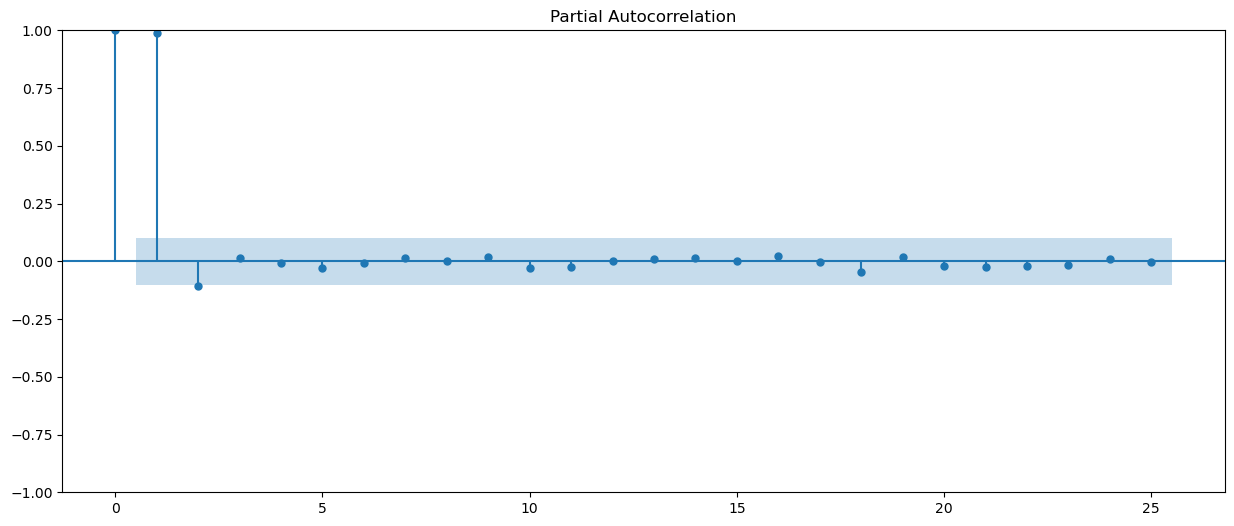

In [83]:
# 3.4 PACF (Partial Autocorrelation Function)
plot_pacf(stock.resample(rule='W').mean()['close'],alpha=0.05,lags=25)
plt.show()

In [84]:
# 3.5 Auto Regressive Integrated Moving Average

appl = stock.copy()
appl['close'].index = pd.DatetimeIndex(appl['close'].index).to_period('D')
aic = []
bic = []
result = []
for i in range(1,7):
    mod = ARIMA(appl['close'], order=(i,0,0))
    res = mod.fit()
    aic.append(res.aic)
    bic.append(res.bic)
    result.append(res)

best_bic = bic.index(min(bic))+1
best_aic = aic.index(min(aic))+1
print('best value for p with respect to BIC : %10.3f' % best_bic)
print('best value for p with respect to AIC : %10.3f' % best_aic)
print(result[best_bic-1].summary())
print(result[best_bic-1].params)

best value for p with respect to BIC :      1.000
best value for p with respect to AIC :      1.000
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1762
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3018.010
Date:                Tue, 05 Mar 2024   AIC                           6042.019
Time:                        18:34:06   BIC                           6058.442
Sample:                    01-04-2010   HQIC                          6048.088
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.9201     22.484      3.510      0.000      34.853     122.987
ar.L1          0.9993      0.00

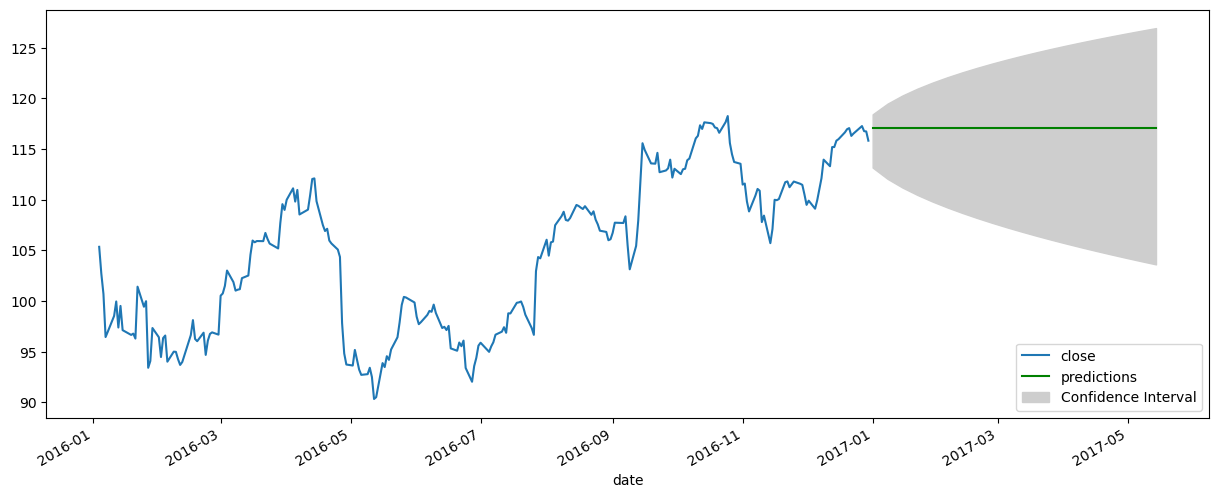

In [85]:
# 3.5.2 Plotting ARIMA

fig1, ax2 = plt.subplots()
ax2 = appl.loc['2016','close'].plot(ax=ax2)

prediction_start_index = appl.index[-1]+pd.DateOffset(weeks=0)
prediction_end_index = appl.index[-1]+pd.DateOffset(weeks=20)

predictions = result[best_bic-1].predict(start=appl.index[-1]-pd.DateOffset(weeks=10), end=appl.index[-1])
forecast = result[best_bic-1].get_forecast(steps=20)

confidence_intervals = forecast.conf_int()

pred = pd.DataFrame({'predicted':predictions[0],
                     'lower':[confidence_intervals['lower close'].values[i] for i in range(len(confidence_intervals))],
                     'upper':[confidence_intervals['upper close'].values[i] for i in range(len(confidence_intervals))]},
                    index=prediction_index)

fig1 = pred['predicted'].plot(ax=ax2,color="green",label='predictions')
plt.fill_between(pred.index,pred['lower'],pred['upper'],color="#CECECE",label='Confidence Interval')
rcParams["legend.loc"] = 'lower right'
plt.legend()
plt.show()

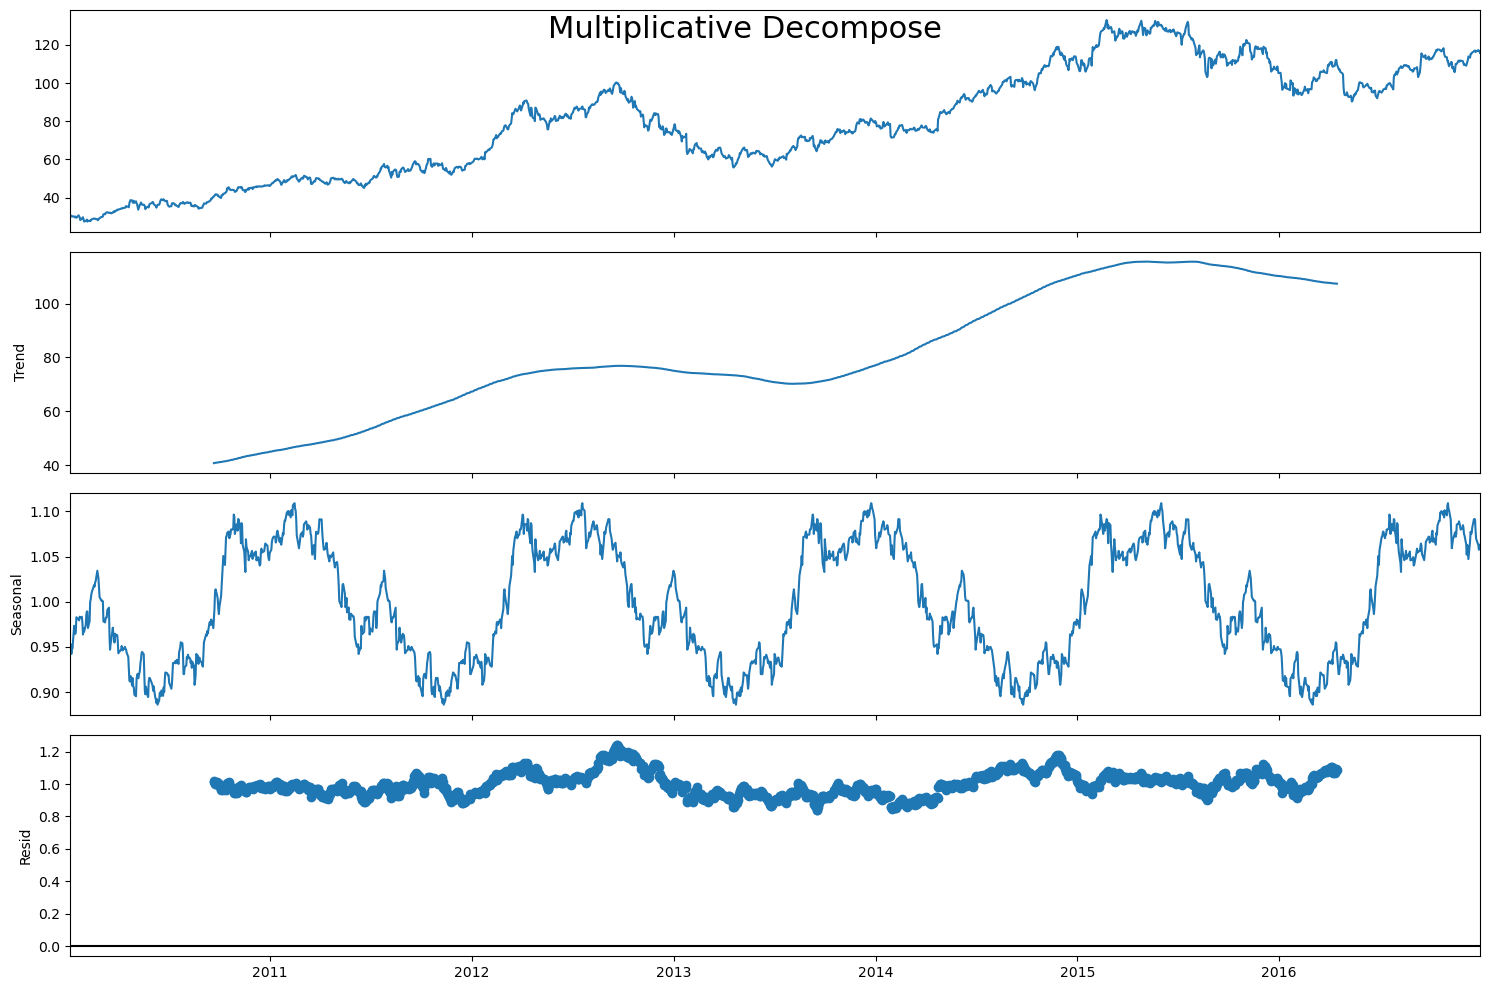

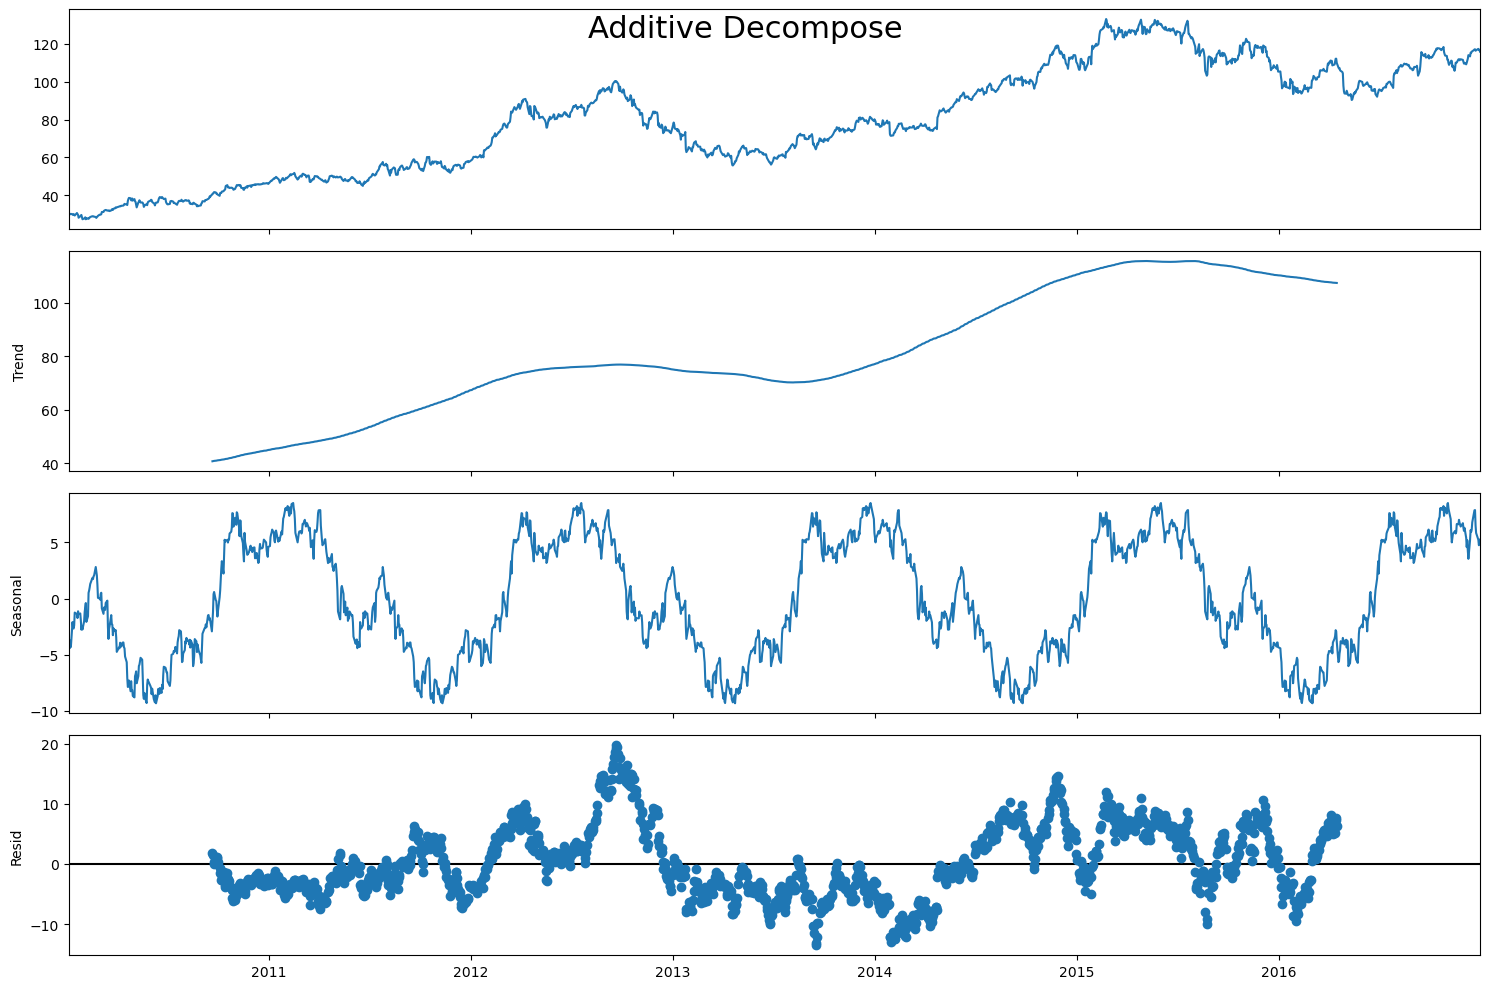

In [86]:
# 3.6 Multiplicative & Additive Decompose

plt.rcParams.update({'figure.figsize': (15,10)})
multiplicative = sm.tsa.seasonal_decompose(stock["close"].to_frame(),period=360,model='multiplicative')
multiplicative.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.show()

additive = sm.tsa.seasonal_decompose(stock["close"].to_frame(),period=360,model='additive')
additive.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()
plt.rcParams.update({'figure.figsize': (15,5)})

In [87]:
# 3.7 Checking if the residuals follow a normal distribution and there is no pattern, comparing it with generated normal distribution

residuals = multiplicative.resid
normal_distribution = np.random.normal(loc=multiplicative.resid.mean(), scale=multiplicative.resid.std(),size=len(multiplicative.resid))

import plotly.graph_objects as go

histfig = go.Figure()
histfig.add_trace(go.Histogram(x=residuals))
histfig.add_trace(go.Histogram(x=normal_distribution))

histfig.update_layout(barmode='overlay')
histfig.update_traces(opacity=0.5)
histfig.show()

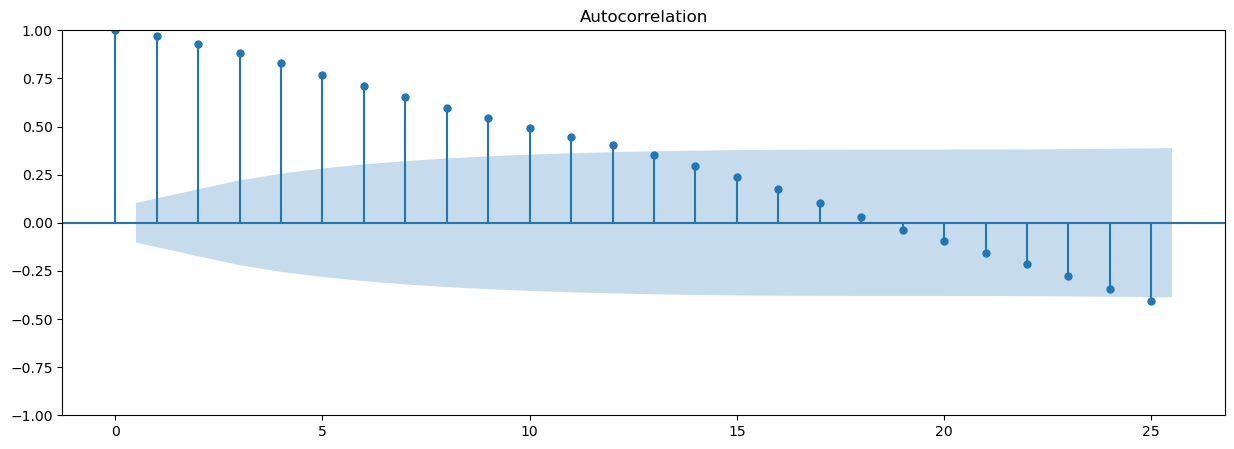

In [88]:
# 3. 8 Seasonal Autocorrelation
amzn_seasonal = multiplicative.seasonal

plot_acf(amzn_seasonal.resample(rule='W').mean(),alpha=0.05,lags=25)
plt.show()

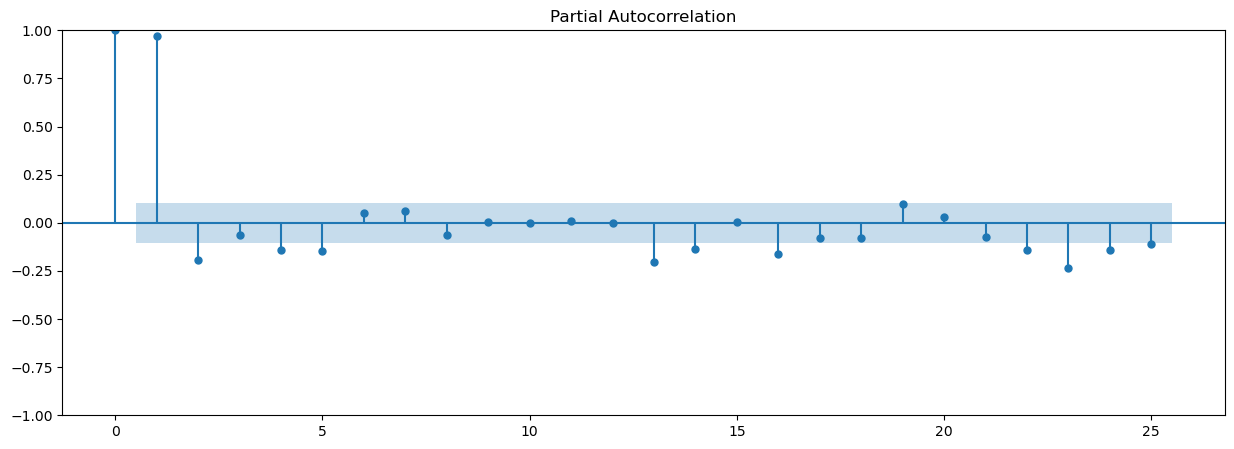

In [89]:
# 3.9 seasonal pacf
plot_pacf(amzn_seasonal.resample(rule='W').mean(),alpha=0.05,lags=25)
plt.show()

In [90]:
# 3.10 Performing stepwise search to minimize aic
appl_2 = appl.copy()
appl_2['mean'] = (appl_2['low'] + appl_2['high'])/2

steps=-1
appl_2['actual']=appl_2['mean'].shift(steps)
appl_2.dropna(inplace=True)

sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(appl_2[['low', 'high','open', 'close', 'volume']])
X = pd.DataFrame(scaled_input)

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(appl_2['actual'].values.reshape(-1,1))
y = pd.DataFrame(scaler_output)

split_size = 0.7
train_size=int(len(appl['close']) * split_size)
test_size = int(len(appl['close'])) - train_size
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

step_wise = auto_arima(train_y, exogenous= train_X,
                       start_p=1, start_q=1, 
                       max_p=7, max_q=7, d=1, max_d=7, 
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=True) #

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8059.408, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8013.390, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8057.853, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8061.429, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8008.854, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8059.540, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8057.581, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8058.744, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.826 seconds


In [91]:
# 3.11 SARIMAX

model = SARIMAX(train_y, exog=train_X[3], order=(1,1,3),seasonal_order=(1,0,0,12),seasonal=True, enforce_invertibility=False, enforce_stationarity=False)

sarimax_results = model.fit()

predictions = sarimax_results.predict(start=train_size, end=train_size+test_size+(steps)-1, exog=test_X[3])

forecast = sarimax_results.forecast(steps=test_size-1, exog=test_X[3])

C:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\brand\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [92]:
# 3.11.2 SARIMAX Model Evaluation
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions.values, test_y[0].values)
error

0.012680650616812821

C:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\brand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



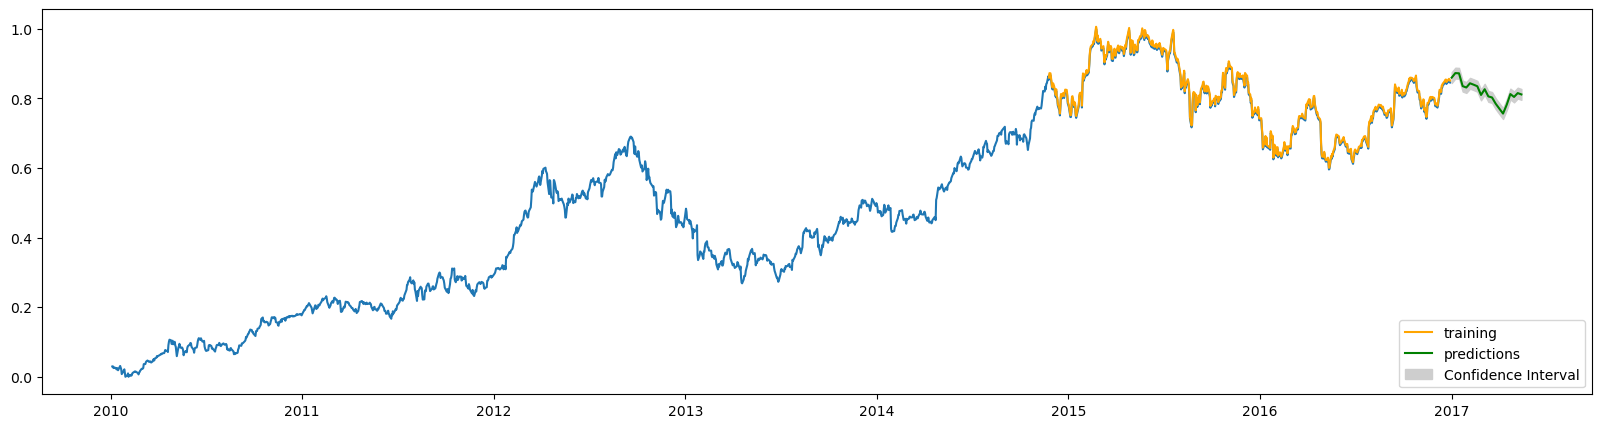

In [93]:
# 3.11.2 SARIMAX Plotting

fig4 = plt.figure(figsize=(20,5))
ax5 = plt.plot(appl.index[0:-1],X[3])

prediction_start_index = appl.index[-1]+pd.DateOffset(weeks=0)
prediction_end_index = appl.index[-1]+pd.DateOffset(weeks=20)

test_predictions = sarimax_results.predict(start=train_size, end=train_size+test_size+(steps)-1, exog=test_X[3])
ax5 = plt.plot(appl.index[train_size:train_size+test_size+(steps)],test_predictions.values,color="orange",label="training")

prediction_index = pd.date_range(start=prediction_start_index,end=prediction_end_index,freq="W")
predictions = sarimax_results.forecast(steps=20,exog=test_X[3][0:20])
fcast = sarimax_results.get_forecast(20,exog=test_X[3][0:20])
confidence_intervals = fcast.conf_int()

pred = pd.DataFrame({'predicted':predictions.values,
                     'lower':confidence_intervals['lower y'].values,
                     'upper':confidence_intervals['upper y'].values},
                    index=prediction_index)

ax5 = plt.plot(pred.index,pred['predicted'],color="green",label='predictions')
plt.fill_between(pred.index,pred['lower'],pred['upper'],color="#CECECE",label='Confidence Interval')
rcParams["legend.loc"] = 'lower right'
plt.legend()
plt.show()